In [1]:
import numpy as np
import itertools
import random
from sklearn.compose import ColumnTransformer
from sklearn.datasets import fetch_openml
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split, GridSearchCV
import pandas as pd

from jenga.cleaning.ppp import PipelineWithPPP
from jenga.cleaning.autoclean import AutoClean
from jenga.cleaning.outlier_removal import SKLearnIsolationForest
from jenga.cleaning.imputation import SimpleImputation

from jenga.corruptions.categorical import SwapValues
from jenga.corruptions.numerical import SwappedValues, Outliers, Scaling
from jenga.corruptions.text import BrokenCharacters
from jenga.corruptions.missing import ( MissingValuesHighEntropy, 
                                  MissingValuesLowEntropy, 
                                  MissingValues
                                )


# Titanic Example

In [2]:

np.random.seed(0)

# Load data from https://www.openml.org/d/40945
X, y = fetch_openml("titanic", version=1, as_frame=True, return_X_y=True)

# Alternatively X and y can be obtained directly from the frame attribute:
# X = titanic.frame.drop('survived', axis=1)
# y = titanic.frame['survived']

# We will train our classifier with the following features:
# Numeric Features:
# - age: float.
# - fare: float.
# Categorical Features:
# - embarked: categories encoded as strings {'C', 'S', 'Q'}.
# - sex: categories encoded as strings {'female', 'male'}.
# - pclass: ordinal integers {1, 2, 3}.

# We create the preprocessing pipelines for both numeric and categorical data.
numeric_features = ['age', 'fare']
numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())])

categorical_features = ['embarked', 'sex', 'pclass']
categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='constant', fill_value='missing')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))])

preprocessor = ColumnTransformer(
    transformers=[
        ('numerical_features', numeric_transformer, numeric_features),
        ('categorical_features', categorical_transformer, categorical_features)])

# Append classifier to preprocessing pipeline.
# Now we have a full prediction pipeline.
clf = Pipeline(steps=[('preprocessor', preprocessor),
                      ('classifier', LogisticRegression())])

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

clf.fit(X_train, y_train)
print("model score: %.3f" % clf.score(X_test, y_test))

model score: 0.790


## PPP Model

In [3]:
from jenga.cleaning.ppp import PipelineWithPPP
ppp = PipelineWithPPP(clf, 
                      numerical_columns=numeric_features, 
                      categorical_columns=categorical_features,
                      num_repetitions=5,
                      perturbation_fractions=[.3, .5, .6, .75, .9]
                     )
ppp.fit_ppp(X_train, y_train)
print(f'Predicted score: {ppp.predict_ppp(X_test):.4f}, true score {clf.score(X_test, y_test):.4f}')

Predicted score: 0.7833, true score 0.7863


/Users/felix/anaconda3/envs/ppp/lib/python3.6/site-packages/pandas/core/frame.py:3509: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[k1] = value[k2]


In [24]:
# perturbation = Scaling(0.2, ['age','fare'])
perturbation = SwappedValues(0.4, ['age','fare'])
# perturbation = MissingValues(0.7, 'fare',0,'MAR')
X_corrupted = perturbation(X_test.copy())

ac = AutoClean(X_train, 
               y_train, 
               clf, 
               numerical_columns=['age','fare'], 
               categorical_columns=['embarked', 'sex', 'pclass'],
               outlier_removal=[SKLearnIsolationForest],
               imputation=[SimpleImputation],
               verbose=True
              )
X_cleaned, predicted_score_no_cleaning, cleaner_results_ppp, cleaner_results_true = ac(X_corrupted.copy(deep=True), test_labels=y_test)

result = {
        'perturbation': perturbation,
        'clean_data_test_score': clf.score(X_test, y_test),
        'corrupted_data_test_score': clf.score(X_corrupted, y_test),
        'cleaned_data_test_score': clf.score(X_cleaned, y_test),
        'ppp_score_corrupted': ppp.predict_ppp(X_corrupted),
        'ppp_score_cleaned': ppp.predict_ppp(X_cleaned)
    }
print('\n'.join([f'{k}:{v}' for k,v in result.items()]))
    

PPP score no cleaning 0.7807067812798472
PPP score with cleaning <class 'jenga.cleaning.imputation.Imputation'>: 0.7807067812798472
True score with cleaning <class 'jenga.cleaning.imputation.Imputation'>: 0.7709923664122137
PPP score with cleaning <class 'jenga.cleaning.imputation.SimpleImputation'>: 0.7807067812798472
True score with cleaning <class 'jenga.cleaning.imputation.SimpleImputation'>: 0.7709923664122137
Setting 121 to NaN
PPP score with cleaning <class 'jenga.cleaning.imputation.Imputation'>: 0.7141356255969438
True score with cleaning <class 'jenga.cleaning.imputation.Imputation'>: 0.6717557251908397
Setting 121 to NaN
PPP score with cleaning <class 'jenga.cleaning.imputation.SimpleImputation'>: 0.6700095510983765
True score with cleaning <class 'jenga.cleaning.imputation.SimpleImputation'>: 0.6450381679389313
Cleaning did not improve score
perturbation:<jenga.corruptions.numerical.SwappedValues object at 0x1212a6780>
clean_data_test_score:0.7862595419847328
corrupted_data

In [5]:
cleaner_results_ppp, cleaner_results_true

([0.7758675581025151,
  0.7758675581025151,
  0.7161413562559693,
  0.6783826806749443],
 [0.7900763358778626,
  0.7900763358778626,
  0.6641221374045801,
  0.6297709923664122])

# Toy Data Example

(-1.8774763389668039, 4.73916889797604, -1.7047546030348233, 6.633577833428513)

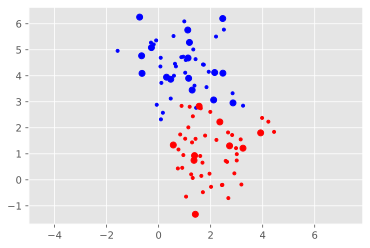

In [6]:
%matplotlib inline
%config InlineBackend.figure_format = 'svg'
import matplotlib.pyplot as plt
plt.style.use('ggplot')
import pandas as pd
import numpy as np
import seaborn as sns
from sklearn.datasets import make_blobs

X, y = make_blobs(n_samples=100, centers=2, n_features=2, random_state=0)
X_train, X_test, y_train, y_test = train_test_split(X, y)
X_train, X_test = pd.DataFrame(X_train), pd.DataFrame(X_test)

plt.plot(X_train.loc[y_train>0,0],X_train.loc[y_train>0,1],'r.',
         X_train.loc[y_train<=0,0],X_train.loc[y_train<=0,1],'b.',
        )
plt.plot(X_test.loc[y_test>0,0],X_test.loc[y_test>0,1],'ro',
         X_test.loc[y_test<=0,0],X_test.loc[y_test<=0,1],'bo',
        )
plt.axis('equal')

(-1.8774763389668039, 4.73916889797604, -19.63658759940885, 19.41074815055588)

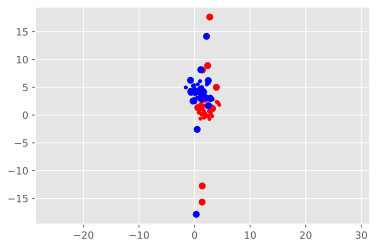

In [16]:
perturbation = Outliers(0.5, [1])
X_corrupted = perturbation(X_test.copy())

plt.plot(X_train.loc[y_train>0,0],X_train.loc[y_train>0,1],'r.',
         X_train.loc[y_train<=0,0],X_train.loc[y_train<=0,1],'b.',
        )
plt.plot(X_corrupted.loc[y_test>0,0],X_corrupted.loc[y_test>0,1],'ro',
         X_corrupted.loc[y_test<=0,0],X_corrupted.loc[y_test<=0,1],'bo',
        )
plt.axis('equal')

In [17]:
# We create the preprocessing pipelines for both numeric and categorical data.
numeric_features = [0,1]
numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())])

preprocessor = ColumnTransformer(
    transformers=[
        ('numerical_features', numeric_transformer, numeric_features)])

# Append classifier to preprocessing pipeline.
# Now we have a full prediction pipeline.
clf = Pipeline(steps=[('preprocessor', preprocessor),
                      ('classifier', LogisticRegression())])
clf = clf.fit(X_train, y_train)
print(f'Clean Test Score {clf.score(X_test, y_test)}')
print(f'Corrupted Test Score {clf.score(X_corrupted, y_test)}')

Clean Test Score 0.92
Corrupted Test Score 0.64


In [18]:
from jenga.cleaning.ppp import PipelineWithPPP
ppp = PipelineWithPPP(clf, 
                      numerical_columns=numeric_features, 
                      categorical_columns=[],
                      num_repetitions=5,
                      perturbation_fractions=[.1,.3, .5, .6, .75, .9, .99]
                     )

ppp.fit_ppp(X_train, y_train)
print(f'Predicted clean score: {ppp.predict_ppp(X_test):.4f}, true score {clf.score(X_test, y_test):.4f}')
print(f'Predicted corrupted score: {ppp.predict_ppp(X_corrupted):.4f}, true score {clf.score(X_corrupted, y_test):.4f}')


Predicted clean score: 0.8800, true score 0.9200
Predicted corrupted score: 0.7484, true score 0.6400


In [19]:
ac = AutoClean(X_train, 
               y_train, 
               clf, 
               numerical_columns=[0,1], 
               categorical_columns=[],
               outlier_removal=[SKLearnIsolationForest],
               imputation=[SimpleImputation]
              )
X_cleaned, predicted_score, cleaner_results_ppp, cleaner_results_true  = ac(X_corrupted.copy(deep=True), y_test)

result = {
        'perturbation': perturbation,
        'clean_data_test_score': clf.score(X_test, y_test),
        'corrupted_data_test_score': clf.score(X_corrupted, y_test),
        'cleaned_data_test_score': clf.score(X_cleaned, y_test),
        'ppp_score_corrupted': ppp.predict_ppp(X_corrupted),
        'ppp_score_cleaned': ppp.predict_ppp(X_cleaned)
    }
print('\n'.join([f'{k}:{v}' for k,v in result.items()]))
    

perturbation:<jenga.corruptions.numerical.Outliers object at 0x135f29a58>
clean_data_test_score:0.92
corrupted_data_test_score:0.64
cleaned_data_test_score:0.6
ppp_score_corrupted:0.7484444444444445
ppp_score_cleaned:0.7866666666666666


In [20]:
cleaner_results_ppp, cleaner_results_true

([0.776, 0.776, 0.8453333333333333, 0.8640000000000001],
 [0.64, 0.64, 0.64, 0.6])

# OpenML Example

In [34]:
def _is_categorical(col: pd.Series,
                    n_samples: int = 100,
                    max_unique_fraction=0.05) -> bool:
    """
    A heuristic to check whether a column is categorical:
    a column is considered categorical (as opposed to a plain text column)
    if the relative cardinality is max_unique_fraction or less.
    :param col: pandas Series containing strings
    :param n_samples: number of samples used for heuristic (default: 100)
    :param max_unique_fraction: maximum relative cardinality.
    :return: True if the column is categorical according to the heuristic
    """

    sample = col.sample(n=n_samples, replace=len(col) < n_samples).unique()

    return sample.shape[0] / n_samples < max_unique_fraction

corruptions = {
    'numeric':[Outliers, Scaling],
    'categorical':[SwapValues],
    'missing': [MissingValuesHighEntropy, 
                MissingValuesLowEntropy, 
                MissingValues]
}

def get_random_perturbation(numerical_columns, 
                            categorical_columns, 
                            fractions=[.5, .7, .9]):
    '''
    Returns a random perturbation, chosen from either a numeric (swapping, outlier, scaling)
    or missingness
    '''
    
    if len(numerical_columns)>0 and len(categorical_columns)>0:
        perturbation_type = random.choice(list(corruptions.keys()))
    elif len(numerical_columns)>0:
        perturbation_type = 'numeric'
    elif len(categorical_columns)>0:
        perturbation_type = 'categorical'
    else:
        print("need at least one categorical or numeric column")
        
    random_fraction = random.choice(fractions)
    if perturbation_type is 'missing':
        missingness = random.choice(['MCAR', 'MAR', 'MNAR'])
        rand_column = random.choice(categorical_columns + numerical_columns)
        if rand_column in numerical_columns:
            missing_value = 0
        else:
            missing_value = ''
        return MissingValues(random_fraction, rand_column, None, missingness)
    elif perturbation_type is 'numeric':
        perturbation = random.choice(corruptions[perturbation_type])
        rand_column = random.choice(numerical_columns)
        return perturbation(random_fraction, [rand_column])
    elif perturbation_type is 'categorical':
        rand_column = random.choice(categorical_columns)
        return SwapValues(random_fraction, rand_column)
    
experiments = ['ionosphere','sonar','heart-statlog','parkinsons']


In [35]:
def run_experiment(exp_id):
    print(f'Fetching dataset {exp_id}')
    X, y = fetch_openml(exp_id, version=1, as_frame=True, return_X_y=True)

    categorical_features = [c for c in X.columns if _is_categorical(X[c])]
    X[categorical_features] = X[categorical_features].astype(str)
    numeric_features = list(set(X.columns) - set(categorical_features))
    print(f"Found {len(categorical_features)} categorical and {len(numeric_features)} numeric features")


    # We create the preprocessing pipelines for both numeric and categorical data.
    numeric_transformer = Pipeline(steps=[
        ('imputer', SimpleImputer(strategy='median')),
        ('scaler', StandardScaler())])

    categorical_transformer = Pipeline(steps=[
        ('imputer', SimpleImputer(strategy='constant', fill_value='missing')),
        ('onehot', OneHotEncoder(handle_unknown='ignore'))])

    preprocessor = ColumnTransformer(
        transformers=[
            ('numerical_features', numeric_transformer, numeric_features),
            ('categorical_features', categorical_transformer, categorical_features)])

    # Append classifier to preprocessing pipeline.
    # Now we have a full prediction pipeline.
    clf = Pipeline(steps=[('preprocessor', preprocessor),
                          ('classifier', LogisticRegression())])

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

    clf.fit(X_train, y_train)
    print("model score: %.3f" % clf.score(X_test, y_test))

    ppp = PipelineWithPPP(clf, 
                          numerical_columns=numeric_features, 
                          categorical_columns=categorical_features,
                          num_repetitions=10,
                          perturbation_fractions=[.5, .6, .75, .9]
                         )
    ppp.fit_ppp(X_train, y_train)
    print(f'Predicted score: {ppp.predict_ppp(X_test):.4f}, true score {clf.score(X_test, y_test):.4f}')
    print("*"*80)
    perturbation = get_random_perturbation(numeric_features, categorical_features)
    print(perturbation)
    X_corrupted = perturbation(X_test.copy())

    ac = AutoClean(X_train, 
                   y_train, 
                   clf, 
                   numerical_columns=numeric_features, 
                   categorical_columns=categorical_features,
                   outlier_removal=[SKLearnIsolationForest],
                   imputation=[SimpleImputation],
                   verbose=True
                  )
    X_cleaned, predicted_score_no_cleaning, cleaner_results_ppp, cleaner_results_true = ac(X_corrupted.copy(deep=True), test_labels=y_test)

    result = {
            'perturbation': perturbation,
            'clean_data_test_score': clf.score(X_test, y_test),
            'corrupted_data_test_score': clf.score(X_corrupted, y_test),
            'cleaned_data_test_score': clf.score(X_cleaned, y_test),
            'ppp_score_corrupted': ppp.predict_ppp(X_corrupted),
            'ppp_score_cleaned': ppp.predict_ppp(X_cleaned),
            'cleaner_results_ppp': cleaner_results_ppp,
            'cleaner_results_true': cleaner_results_true,
        }
    print('\n'.join([f'{k}:{v}' for k,v in result.items()]))
    return result

In [36]:
results = []
for _ in range(100):
    try:
        results.append(run_experiment(random.choice(experiments)))
    except:
        pass

Fetching dataset ionosphere
Found 2 categorical and 32 numeric features
model score: 0.873


/Users/felix/anaconda3/envs/ppp/lib/python3.6/site-packages/pandas/core/frame.py:3509: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[k1] = value[k2]


Predicted score: 0.8800, true score 0.8732
********************************************************************************
Scaling: {'fraction': 0.5, 'columns': ['a04']}
PPP score no cleaning 0.8957142857142857
PPP score with cleaning <class 'jenga.cleaning.imputation.Imputation'>: 0.896
True score with cleaning <class 'jenga.cleaning.imputation.Imputation'>: 0.901
PPP score with cleaning <class 'jenga.cleaning.imputation.SimpleImputation'>: 0.896
True score with cleaning <class 'jenga.cleaning.imputation.SimpleImputation'>: 0.901
Setting 7 to NaN
PPP score with cleaning <class 'jenga.cleaning.imputation.Imputation'>: 0.876
True score with cleaning <class 'jenga.cleaning.imputation.Imputation'>: 0.901
Setting 7 to NaN
PPP score with cleaning <class 'jenga.cleaning.imputation.SimpleImputation'>: 0.909
True score with cleaning <class 'jenga.cleaning.imputation.SimpleImputation'>: 0.803
Best outlier removal <class 'type'> + best imputation <class 'type'>: 0.909
perturbation:Scaling: {'fr

/Users/felix/anaconda3/envs/ppp/lib/python3.6/site-packages/pandas/core/frame.py:3509: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[k1] = value[k2]


Predicted score: 0.7733, true score 0.8873
********************************************************************************
SwapValues: {'fraction': 0.9, 'column': 'a01'}
PPP score no cleaning 0.5239285714285714
PPP score with cleaning <class 'jenga.cleaning.imputation.Imputation'>: 0.524
True score with cleaning <class 'jenga.cleaning.imputation.Imputation'>: 0.592
PPP score with cleaning <class 'jenga.cleaning.imputation.SimpleImputation'>: 0.524
True score with cleaning <class 'jenga.cleaning.imputation.SimpleImputation'>: 0.592
Setting 7 to NaN
PPP score with cleaning <class 'jenga.cleaning.imputation.Imputation'>: 0.524
True score with cleaning <class 'jenga.cleaning.imputation.Imputation'>: 0.577
Setting 7 to NaN
PPP score with cleaning <class 'jenga.cleaning.imputation.SimpleImputation'>: 0.521
True score with cleaning <class 'jenga.cleaning.imputation.SimpleImputation'>: 0.577
Cleaning did not improve score
perturbation:SwapValues: {'fraction': 0.9, 'column': 'a01'}
clean_data_

/Users/felix/anaconda3/envs/ppp/lib/python3.6/site-packages/pandas/core/frame.py:3509: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[k1] = value[k2]


Predicted score: 0.8900, true score 0.8732
********************************************************************************
SwapValues: {'fraction': 0.7, 'column': 'a01'}
PPP score no cleaning 0.6621428571428571
PPP score with cleaning <class 'jenga.cleaning.imputation.Imputation'>: 0.662
True score with cleaning <class 'jenga.cleaning.imputation.Imputation'>: 0.493
PPP score with cleaning <class 'jenga.cleaning.imputation.SimpleImputation'>: 0.662
True score with cleaning <class 'jenga.cleaning.imputation.SimpleImputation'>: 0.493
Setting 7 to NaN
PPP score with cleaning <class 'jenga.cleaning.imputation.Imputation'>: 0.777
True score with cleaning <class 'jenga.cleaning.imputation.Imputation'>: 0.479
Setting 7 to NaN
PPP score with cleaning <class 'jenga.cleaning.imputation.SimpleImputation'>: 0.853
True score with cleaning <class 'jenga.cleaning.imputation.SimpleImputation'>: 0.479
Best outlier removal <class 'type'> + best imputation <class 'type'>: 0.853
perturbation:SwapValues: {

/Users/felix/anaconda3/envs/ppp/lib/python3.6/site-packages/pandas/core/frame.py:3509: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[k1] = value[k2]


Predicted score: 0.9007, true score 0.8451
********************************************************************************
MissingValues: {'column': 'a12', 'fraction': 0.5, 'na_value': None, 'missingness': 'MCAR'}
PPP score no cleaning 0.9085714285714286
PPP score with cleaning <class 'jenga.cleaning.imputation.Imputation'>: 0.909
True score with cleaning <class 'jenga.cleaning.imputation.Imputation'>: 0.845
PPP score with cleaning <class 'jenga.cleaning.imputation.SimpleImputation'>: 0.909
True score with cleaning <class 'jenga.cleaning.imputation.SimpleImputation'>: 0.845
Setting 7 to NaN
PPP score with cleaning <class 'jenga.cleaning.imputation.Imputation'>: 0.909
True score with cleaning <class 'jenga.cleaning.imputation.Imputation'>: 0.873
Setting 7 to NaN
PPP score with cleaning <class 'jenga.cleaning.imputation.SimpleImputation'>: 0.909
True score with cleaning <class 'jenga.cleaning.imputation.SimpleImputation'>: 0.775
Cleaning did not improve score
perturbation:MissingValues:

/Users/felix/anaconda3/envs/ppp/lib/python3.6/site-packages/pandas/core/frame.py:3509: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[k1] = value[k2]


Predicted score: 0.8642, true score 0.8519
********************************************************************************
Outliers: {'fraction': 0.5, 'columns': ['serum_cholestoral']}
PPP score no cleaning 0.8682098765432098
PPP score with cleaning <class 'jenga.cleaning.imputation.Imputation'>: 0.868
True score with cleaning <class 'jenga.cleaning.imputation.Imputation'>: 0.833
PPP score with cleaning <class 'jenga.cleaning.imputation.SimpleImputation'>: 0.868
True score with cleaning <class 'jenga.cleaning.imputation.SimpleImputation'>: 0.833
Setting 6 to NaN
PPP score with cleaning <class 'jenga.cleaning.imputation.Imputation'>: 0.876
True score with cleaning <class 'jenga.cleaning.imputation.Imputation'>: 0.796
Setting 6 to NaN
PPP score with cleaning <class 'jenga.cleaning.imputation.SimpleImputation'>: 0.868
True score with cleaning <class 'jenga.cleaning.imputation.SimpleImputation'>: 0.796
Best outlier removal <class 'type'> + best imputation <class 'type'>: 0.876
perturbatio

/Users/felix/anaconda3/envs/ppp/lib/python3.6/site-packages/pandas/core/frame.py:3509: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[k1] = value[k2]


Predicted score: 0.9165, true score 0.7143
********************************************************************************
Scaling: {'fraction': 0.5, 'columns': ['attribute_52']}
PPP score no cleaning 0.7120481927710843
PPP score with cleaning <class 'jenga.cleaning.imputation.Imputation'>: 0.712
True score with cleaning <class 'jenga.cleaning.imputation.Imputation'>: 0.738
PPP score with cleaning <class 'jenga.cleaning.imputation.SimpleImputation'>: 0.712
True score with cleaning <class 'jenga.cleaning.imputation.SimpleImputation'>: 0.738
Setting 5 to NaN
PPP score with cleaning <class 'jenga.cleaning.imputation.Imputation'>: 0.751
True score with cleaning <class 'jenga.cleaning.imputation.Imputation'>: 0.667
Setting 5 to NaN
PPP score with cleaning <class 'jenga.cleaning.imputation.SimpleImputation'>: 0.736
True score with cleaning <class 'jenga.cleaning.imputation.SimpleImputation'>: 0.738
Best outlier removal <class 'type'> + best imputation <class 'type'>: 0.751
perturbation:Scal

/Users/felix/anaconda3/envs/ppp/lib/python3.6/site-packages/pandas/core/frame.py:3509: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[k1] = value[k2]


Predicted score: 0.8803, true score 0.7619
********************************************************************************
Scaling: {'fraction': 0.7, 'columns': ['attribute_29']}
PPP score no cleaning 0.8951807228915662
PPP score with cleaning <class 'jenga.cleaning.imputation.Imputation'>: 0.895
True score with cleaning <class 'jenga.cleaning.imputation.Imputation'>: 0.762
PPP score with cleaning <class 'jenga.cleaning.imputation.SimpleImputation'>: 0.895
True score with cleaning <class 'jenga.cleaning.imputation.SimpleImputation'>: 0.762
Setting 5 to NaN
PPP score with cleaning <class 'jenga.cleaning.imputation.Imputation'>: 0.839
True score with cleaning <class 'jenga.cleaning.imputation.Imputation'>: 0.738
Setting 5 to NaN
PPP score with cleaning <class 'jenga.cleaning.imputation.SimpleImputation'>: 0.921
True score with cleaning <class 'jenga.cleaning.imputation.SimpleImputation'>: 0.762
Best outlier removal <class 'type'> + best imputation <class 'type'>: 0.921
perturbation:Scal

/Users/felix/anaconda3/envs/ppp/lib/python3.6/site-packages/pandas/core/frame.py:3509: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[k1] = value[k2]


Predicted score: 0.8212, true score 0.8462
********************************************************************************
Scaling: {'fraction': 0.5, 'columns': ['V18']}
PPP score no cleaning 0.8032051282051281
PPP score with cleaning <class 'jenga.cleaning.imputation.Imputation'>: 0.803
True score with cleaning <class 'jenga.cleaning.imputation.Imputation'>: 0.795
PPP score with cleaning <class 'jenga.cleaning.imputation.SimpleImputation'>: 0.803
True score with cleaning <class 'jenga.cleaning.imputation.SimpleImputation'>: 0.795
Setting 4 to NaN
PPP score with cleaning <class 'jenga.cleaning.imputation.Imputation'>: 0.827
True score with cleaning <class 'jenga.cleaning.imputation.Imputation'>: 0.795
Setting 4 to NaN
PPP score with cleaning <class 'jenga.cleaning.imputation.SimpleImputation'>: 0.827
True score with cleaning <class 'jenga.cleaning.imputation.SimpleImputation'>: 0.795
Best outlier removal <class 'type'> + best imputation <class 'type'>: 0.827
perturbation:Scaling: {'fr

/Users/felix/anaconda3/envs/ppp/lib/python3.6/site-packages/pandas/core/frame.py:3509: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[k1] = value[k2]


Predicted score: 0.8641, true score 0.8718
********************************************************************************
Outliers: {'fraction': 0.5, 'columns': ['V8']}
PPP score no cleaning 0.8606837606837607
PPP score with cleaning <class 'jenga.cleaning.imputation.Imputation'>: 0.861
True score with cleaning <class 'jenga.cleaning.imputation.Imputation'>: 0.949
PPP score with cleaning <class 'jenga.cleaning.imputation.SimpleImputation'>: 0.861
True score with cleaning <class 'jenga.cleaning.imputation.SimpleImputation'>: 0.949
Setting 4 to NaN
PPP score with cleaning <class 'jenga.cleaning.imputation.Imputation'>: 0.826
True score with cleaning <class 'jenga.cleaning.imputation.Imputation'>: 0.923
Setting 4 to NaN
PPP score with cleaning <class 'jenga.cleaning.imputation.SimpleImputation'>: 0.842
True score with cleaning <class 'jenga.cleaning.imputation.SimpleImputation'>: 0.923
Cleaning did not improve score
perturbation:Outliers: {'fraction': 0.5, 'columns': ['V8']}
clean_data_

/Users/felix/anaconda3/envs/ppp/lib/python3.6/site-packages/pandas/core/frame.py:3509: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[k1] = value[k2]


Predicted score: 0.9093, true score 0.8451
********************************************************************************
MissingValues: {'column': 'a08', 'fraction': 0.9, 'na_value': None, 'missingness': 'MNAR'}
PPP score no cleaning 0.9264285714285714
PPP score with cleaning <class 'jenga.cleaning.imputation.Imputation'>: 0.926
True score with cleaning <class 'jenga.cleaning.imputation.Imputation'>: 0.817
PPP score with cleaning <class 'jenga.cleaning.imputation.SimpleImputation'>: 0.926
True score with cleaning <class 'jenga.cleaning.imputation.SimpleImputation'>: 0.817
Setting 7 to NaN
PPP score with cleaning <class 'jenga.cleaning.imputation.Imputation'>: 0.929
True score with cleaning <class 'jenga.cleaning.imputation.Imputation'>: 0.803
Setting 7 to NaN
PPP score with cleaning <class 'jenga.cleaning.imputation.SimpleImputation'>: 0.924
True score with cleaning <class 'jenga.cleaning.imputation.SimpleImputation'>: 0.732
Best outlier removal <class 'type'> + best imputation <cla

/Users/felix/anaconda3/envs/ppp/lib/python3.6/site-packages/pandas/core/frame.py:3509: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[k1] = value[k2]


Predicted score: 0.8460, true score 0.9259
********************************************************************************
SwapValues: {'fraction': 0.9, 'column': 'slope'}
PPP score no cleaning 0.8629629629629629
PPP score with cleaning <class 'jenga.cleaning.imputation.Imputation'>: 0.863
True score with cleaning <class 'jenga.cleaning.imputation.Imputation'>: 0.907
PPP score with cleaning <class 'jenga.cleaning.imputation.SimpleImputation'>: 0.863
True score with cleaning <class 'jenga.cleaning.imputation.SimpleImputation'>: 0.907
Setting 6 to NaN
PPP score with cleaning <class 'jenga.cleaning.imputation.Imputation'>: 0.845
True score with cleaning <class 'jenga.cleaning.imputation.Imputation'>: 0.815
Setting 6 to NaN
PPP score with cleaning <class 'jenga.cleaning.imputation.SimpleImputation'>: 0.866
True score with cleaning <class 'jenga.cleaning.imputation.SimpleImputation'>: 0.815
Best outlier removal <class 'type'> + best imputation <class 'type'>: 0.866
perturbation:SwapValues:

/Users/felix/anaconda3/envs/ppp/lib/python3.6/site-packages/pandas/core/frame.py:3509: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[k1] = value[k2]


Predicted score: 0.8031, true score 0.8333
********************************************************************************
Outliers: {'fraction': 0.5, 'columns': ['maximum_heart_rate_achieved']}
PPP score no cleaning 0.8169753086419753
PPP score with cleaning <class 'jenga.cleaning.imputation.Imputation'>: 0.817
True score with cleaning <class 'jenga.cleaning.imputation.Imputation'>: 0.778
PPP score with cleaning <class 'jenga.cleaning.imputation.SimpleImputation'>: 0.817
True score with cleaning <class 'jenga.cleaning.imputation.SimpleImputation'>: 0.778
Setting 6 to NaN
PPP score with cleaning <class 'jenga.cleaning.imputation.Imputation'>: 0.854
True score with cleaning <class 'jenga.cleaning.imputation.Imputation'>: 0.741
Setting 6 to NaN
PPP score with cleaning <class 'jenga.cleaning.imputation.SimpleImputation'>: 0.874
True score with cleaning <class 'jenga.cleaning.imputation.SimpleImputation'>: 0.741
Best outlier removal <class 'type'> + best imputation <class 'type'>: 0.874
p

/Users/felix/anaconda3/envs/ppp/lib/python3.6/site-packages/pandas/core/frame.py:3509: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[k1] = value[k2]


Predicted score: 0.8474, true score 0.7949
********************************************************************************
Outliers: {'fraction': 0.9, 'columns': ['V14']}
PPP score no cleaning 0.838034188034188
PPP score with cleaning <class 'jenga.cleaning.imputation.Imputation'>: 0.838
True score with cleaning <class 'jenga.cleaning.imputation.Imputation'>: 0.795
PPP score with cleaning <class 'jenga.cleaning.imputation.SimpleImputation'>: 0.838
True score with cleaning <class 'jenga.cleaning.imputation.SimpleImputation'>: 0.795
Setting 4 to NaN
PPP score with cleaning <class 'jenga.cleaning.imputation.Imputation'>: 0.77
True score with cleaning <class 'jenga.cleaning.imputation.Imputation'>: 0.692
Setting 4 to NaN
PPP score with cleaning <class 'jenga.cleaning.imputation.SimpleImputation'>: 0.83
True score with cleaning <class 'jenga.cleaning.imputation.SimpleImputation'>: 0.795
Cleaning did not improve score
perturbation:Outliers: {'fraction': 0.9, 'columns': ['V14']}
clean_data_t

/Users/felix/anaconda3/envs/ppp/lib/python3.6/site-packages/pandas/core/frame.py:3509: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[k1] = value[k2]


Predicted score: 0.8603, true score 0.7436
********************************************************************************
Scaling: {'fraction': 0.5, 'columns': ['V13']}
PPP score no cleaning 0.841025641025641
PPP score with cleaning <class 'jenga.cleaning.imputation.Imputation'>: 0.841
True score with cleaning <class 'jenga.cleaning.imputation.Imputation'>: 0.692
PPP score with cleaning <class 'jenga.cleaning.imputation.SimpleImputation'>: 0.841
True score with cleaning <class 'jenga.cleaning.imputation.SimpleImputation'>: 0.692
Setting 4 to NaN
PPP score with cleaning <class 'jenga.cleaning.imputation.Imputation'>: 0.851
True score with cleaning <class 'jenga.cleaning.imputation.Imputation'>: 0.615
Setting 4 to NaN
PPP score with cleaning <class 'jenga.cleaning.imputation.SimpleImputation'>: 0.838
True score with cleaning <class 'jenga.cleaning.imputation.SimpleImputation'>: 0.718
Best outlier removal <class 'type'> + best imputation <class 'type'>: 0.851
perturbation:Scaling: {'fra

/Users/felix/anaconda3/envs/ppp/lib/python3.6/site-packages/pandas/core/frame.py:3509: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[k1] = value[k2]


Predicted score: 0.8673, true score 0.8704
********************************************************************************
Outliers: {'fraction': 0.5, 'columns': ['oldpeak']}
PPP score no cleaning 0.8763888888888889
PPP score with cleaning <class 'jenga.cleaning.imputation.Imputation'>: 0.876
True score with cleaning <class 'jenga.cleaning.imputation.Imputation'>: 0.87
PPP score with cleaning <class 'jenga.cleaning.imputation.SimpleImputation'>: 0.876
True score with cleaning <class 'jenga.cleaning.imputation.SimpleImputation'>: 0.87
Setting 6 to NaN
PPP score with cleaning <class 'jenga.cleaning.imputation.Imputation'>: 0.872
True score with cleaning <class 'jenga.cleaning.imputation.Imputation'>: 0.833
Setting 6 to NaN
PPP score with cleaning <class 'jenga.cleaning.imputation.SimpleImputation'>: 0.875
True score with cleaning <class 'jenga.cleaning.imputation.SimpleImputation'>: 0.833
Cleaning did not improve score
perturbation:Outliers: {'fraction': 0.5, 'columns': ['oldpeak']}
cle

/Users/felix/anaconda3/envs/ppp/lib/python3.6/site-packages/pandas/core/frame.py:3509: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[k1] = value[k2]


Predicted score: 0.8301, true score 0.7381
********************************************************************************
Scaling: {'fraction': 0.5, 'columns': ['attribute_48']}
PPP score no cleaning 0.6716867469879518
PPP score with cleaning <class 'jenga.cleaning.imputation.Imputation'>: 0.672
True score with cleaning <class 'jenga.cleaning.imputation.Imputation'>: 0.667
PPP score with cleaning <class 'jenga.cleaning.imputation.SimpleImputation'>: 0.672
True score with cleaning <class 'jenga.cleaning.imputation.SimpleImputation'>: 0.667
Setting 5 to NaN
PPP score with cleaning <class 'jenga.cleaning.imputation.Imputation'>: 0.758
True score with cleaning <class 'jenga.cleaning.imputation.Imputation'>: 0.595
Setting 5 to NaN
PPP score with cleaning <class 'jenga.cleaning.imputation.SimpleImputation'>: 0.719
True score with cleaning <class 'jenga.cleaning.imputation.SimpleImputation'>: 0.667
Best outlier removal <class 'type'> + best imputation <class 'type'>: 0.758
perturbation:Scal

/Users/felix/anaconda3/envs/ppp/lib/python3.6/site-packages/pandas/core/frame.py:3509: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[k1] = value[k2]


Predicted score: 0.8900, true score 0.8333
********************************************************************************
Outliers: {'fraction': 0.5, 'columns': ['attribute_25']}
PPP score no cleaning 0.844979919678715
PPP score with cleaning <class 'jenga.cleaning.imputation.Imputation'>: 0.845
True score with cleaning <class 'jenga.cleaning.imputation.Imputation'>: 0.833
PPP score with cleaning <class 'jenga.cleaning.imputation.SimpleImputation'>: 0.845
True score with cleaning <class 'jenga.cleaning.imputation.SimpleImputation'>: 0.833
Setting 5 to NaN
PPP score with cleaning <class 'jenga.cleaning.imputation.Imputation'>: 0.809
True score with cleaning <class 'jenga.cleaning.imputation.Imputation'>: 0.762
Setting 5 to NaN
PPP score with cleaning <class 'jenga.cleaning.imputation.SimpleImputation'>: 0.847
True score with cleaning <class 'jenga.cleaning.imputation.SimpleImputation'>: 0.762
Best outlier removal <class 'type'> + best imputation <class 'type'>: 0.847
perturbation:Outl

/Users/felix/anaconda3/envs/ppp/lib/python3.6/site-packages/pandas/core/frame.py:3509: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[k1] = value[k2]


Predicted score: 0.8100, true score 0.8095
********************************************************************************
Scaling: {'fraction': 0.7, 'columns': ['attribute_9']}
PPP score no cleaning 0.7042168674698794
PPP score with cleaning <class 'jenga.cleaning.imputation.Imputation'>: 0.704
True score with cleaning <class 'jenga.cleaning.imputation.Imputation'>: 0.571
PPP score with cleaning <class 'jenga.cleaning.imputation.SimpleImputation'>: 0.704
True score with cleaning <class 'jenga.cleaning.imputation.SimpleImputation'>: 0.571
Setting 5 to NaN
PPP score with cleaning <class 'jenga.cleaning.imputation.Imputation'>: 0.769
True score with cleaning <class 'jenga.cleaning.imputation.Imputation'>: 0.452
Setting 5 to NaN
PPP score with cleaning <class 'jenga.cleaning.imputation.SimpleImputation'>: 0.704
True score with cleaning <class 'jenga.cleaning.imputation.SimpleImputation'>: 0.571
Best outlier removal <class 'type'> + best imputation <class 'type'>: 0.769
perturbation:Scali

/Users/felix/anaconda3/envs/ppp/lib/python3.6/site-packages/pandas/core/frame.py:3509: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[k1] = value[k2]


Predicted score: 0.8707, true score 0.7619
********************************************************************************
Outliers: {'fraction': 0.9, 'columns': ['attribute_2']}
PPP score no cleaning 0.8981927710843373
PPP score with cleaning <class 'jenga.cleaning.imputation.Imputation'>: 0.898
True score with cleaning <class 'jenga.cleaning.imputation.Imputation'>: 0.81
PPP score with cleaning <class 'jenga.cleaning.imputation.SimpleImputation'>: 0.898
True score with cleaning <class 'jenga.cleaning.imputation.SimpleImputation'>: 0.81
Setting 5 to NaN
PPP score with cleaning <class 'jenga.cleaning.imputation.Imputation'>: 0.76
True score with cleaning <class 'jenga.cleaning.imputation.Imputation'>: 0.738
Setting 5 to NaN
PPP score with cleaning <class 'jenga.cleaning.imputation.SimpleImputation'>: 0.898
True score with cleaning <class 'jenga.cleaning.imputation.SimpleImputation'>: 0.738
Cleaning did not improve score
perturbation:Outliers: {'fraction': 0.9, 'columns': ['attribute_2

/Users/felix/anaconda3/envs/ppp/lib/python3.6/site-packages/pandas/core/frame.py:3509: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[k1] = value[k2]


Predicted score: 0.8554, true score 0.8095
********************************************************************************
Scaling: {'fraction': 0.5, 'columns': ['attribute_6']}
PPP score no cleaning 0.7377510040160644
PPP score with cleaning <class 'jenga.cleaning.imputation.Imputation'>: 0.738
True score with cleaning <class 'jenga.cleaning.imputation.Imputation'>: 0.619
PPP score with cleaning <class 'jenga.cleaning.imputation.SimpleImputation'>: 0.738
True score with cleaning <class 'jenga.cleaning.imputation.SimpleImputation'>: 0.619
Setting 5 to NaN
PPP score with cleaning <class 'jenga.cleaning.imputation.Imputation'>: 0.816
True score with cleaning <class 'jenga.cleaning.imputation.Imputation'>: 0.548
Setting 5 to NaN
PPP score with cleaning <class 'jenga.cleaning.imputation.SimpleImputation'>: 0.774
True score with cleaning <class 'jenga.cleaning.imputation.SimpleImputation'>: 0.619
Best outlier removal <class 'type'> + best imputation <class 'type'>: 0.816
perturbation:Scali

/Users/felix/anaconda3/envs/ppp/lib/python3.6/site-packages/pandas/core/frame.py:3509: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[k1] = value[k2]


Predicted score: 0.9000, true score 0.8873
********************************************************************************
SwapValues: {'fraction': 0.7, 'column': 'a02'}
PPP score no cleaning 0.9002380952380953
PPP score with cleaning <class 'jenga.cleaning.imputation.Imputation'>: 0.9
True score with cleaning <class 'jenga.cleaning.imputation.Imputation'>: 0.887
PPP score with cleaning <class 'jenga.cleaning.imputation.SimpleImputation'>: 0.9
True score with cleaning <class 'jenga.cleaning.imputation.SimpleImputation'>: 0.887
Setting 7 to NaN
PPP score with cleaning <class 'jenga.cleaning.imputation.Imputation'>: 0.828
True score with cleaning <class 'jenga.cleaning.imputation.Imputation'>: 0.93
Setting 7 to NaN
PPP score with cleaning <class 'jenga.cleaning.imputation.SimpleImputation'>: 0.899
True score with cleaning <class 'jenga.cleaning.imputation.SimpleImputation'>: 0.831
Cleaning did not improve score
perturbation:SwapValues: {'fraction': 0.7, 'column': 'a02'}
clean_data_test_

/Users/felix/anaconda3/envs/ppp/lib/python3.6/site-packages/pandas/core/frame.py:3509: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[k1] = value[k2]


Predicted score: 0.8542, true score 0.8333
********************************************************************************
MissingValues: {'column': 'resting_electrocardiographic_results', 'fraction': 0.5, 'na_value': None, 'missingness': 'MAR'}
PPP score no cleaning 0.875462962962963
PPP score with cleaning <class 'jenga.cleaning.imputation.Imputation'>: 0.875
True score with cleaning <class 'jenga.cleaning.imputation.Imputation'>: 0.852
PPP score with cleaning <class 'jenga.cleaning.imputation.SimpleImputation'>: 0.881
True score with cleaning <class 'jenga.cleaning.imputation.SimpleImputation'>: 0.833


TypeError: argument must be a string or number